# Notebook for the development of the model to power the face detection

### Imports

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import torch
from PIL import Image
from torchvision.datasets import WIDERFace
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import fasterrcnn_mobilenet_v3_large_320_fpn, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights
from collections import defaultdict
import os
import pathlib
import random
from typing import Tuple, List

### Constants

In [2]:
ROOT = "/content/" # Change to your root directory

### Download Data

In [3]:
WIDERFace(root="", download=True)

Downloading...
From (original): https://drive.google.com/uc?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M
From (redirected): https://drive.usercontent.google.com/download?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M&confirm=t&uuid=de0b6aa5-e3a0-4101-bc8a-ef0fcb599998
To: /content/widerface/WIDER_train.zip
100%|██████████| 1.47G/1.47G [00:36<00:00, 40.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q
From (redirected): https://drive.usercontent.google.com/download?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q&confirm=t&uuid=213beb32-4944-4e6c-b0dd-0780690fbf34
To: /content/widerface/WIDER_val.zip
100%|██████████| 363M/363M [00:10<00:00, 36.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T
From (redirected): https://drive.usercontent.google.com/download?id=1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T&confirm=t&uuid=35bee3fd-1356-41e5-ac8c-7d3a9a7c860e
To: /content/widerface/WIDER_test.zip
100%|██████████| 1.84G/1.84G 

100%|██████████| 3591642/3591642 [00:00<00:00, 38715911.01it/s]

Extracting widerface/wider_face_split.zip to widerface


Dataset WIDERFace
    Number of datapoints: 12880
    Root location: widerface
    Split: train

## Data Exploration

### Build dictionary with image name and folder as key and a list with the number of faces and the coordinates of the bounding boxes as value

In [4]:
# Make list from ground truth .txt file
ground_truth_file_list = []
with open(ROOT + "widerface/wider_face_split/wider_face_train_bbx_gt.txt") as file:
  for line in file:
    ground_truth_file_list.append(line.strip())

In [26]:
images_ground_truth = {}
index = 0
while index < len(ground_truth_file_list):
  if len(ground_truth_file_list[index].split(".")) == 2:
    image_name = ground_truth_file_list[index].strip()
    index += 1
    num_faces = int(ground_truth_file_list[index].strip())
    ground_truth = [num_faces]
    for _ in range(num_faces):
      index += 1
      ground_truth.append(list(map(lambda x: int(x), ground_truth_file_list[index].split(" ")))[:4]) # only num_faces / x, y, width, height
    images_ground_truth[image_name] = ground_truth
  index += 1

### Visualize 4 random example images with bounding boxes

In [7]:
def plot_image(axs, x, y, image):
  ground_truth = images_ground_truth[image]
  axs[x, y].imshow(mpimg.imread(ROOT + "widerface/WIDER_train/images/" + image))
  for rect in ground_truth[1:]:
    rect_x, rect_y, width, height = rect
    rect_obj = patches.Rectangle((rect_x, rect_y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    axs[x, y].add_patch(rect_obj)
  image_name = image.split("/")[1].split(".")[0]
  axs[x, y].set_title(image_name)

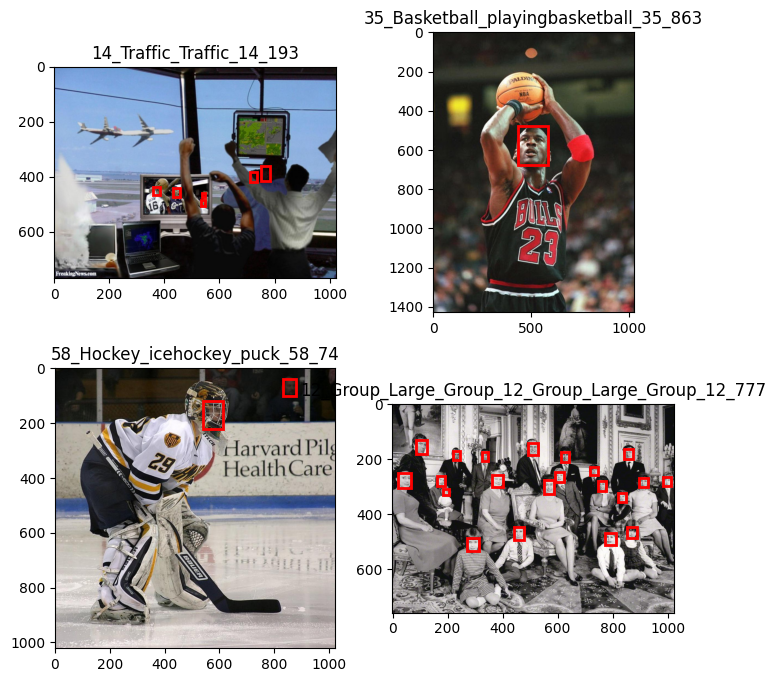

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

images = random.sample(list(images_ground_truth.keys()), 4)
# Plot first image
plot_image(axs, 0, 0, images[0])
# Plot second image
plot_image(axs, 0, 1, images[1])
# Plot third image
plot_image(axs, 1, 0, images[2])
# Plot fourth image
plot_image(axs, 1, 1, images[3])

### Explore Distribution over number of faces
-> Use log scale to better visualize extreme values

In [9]:
dist_num_faces = defaultdict(int)
with open(ROOT + "widerface/wider_face_split/wider_face_train_bbx_gt.txt") as file:
  for line in file:
    if len(line.split(" ")) == 1 and len(line.split(".")) == 1:
      dist_num_faces[int(line)] += 1
print(f"There are {dist_num_faces[0]} images with zero faces.")

There are 4 images with zero faces.


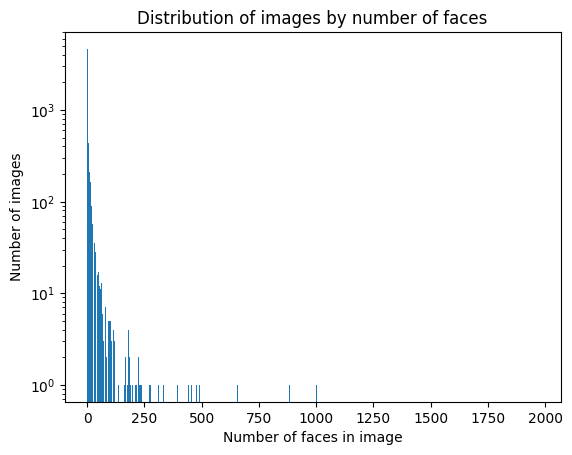

In [10]:
num_faces = list(dist_num_faces.keys())
frequency = list(dist_num_faces.values())

plt.bar(num_faces, frequency, log=True)
plt.xlabel('Number of faces in image')
plt.ylabel('Number of images')
plt.title('Distribution of images by number of faces')

plt.show()

## Build Data Loaders

In [11]:
# auto transformation
weights = FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT
transforms = weights.transforms()

Build DataSet

In [16]:
base_path = ROOT + "widerface/WIDER_train/images/"
image_paths = [base_path + image_name for image_name in images_ground_truth]
annotations = []
for image_name in images_ground_truth:
  annotation = {"boxes": [], "labels": []}
  for box in images_ground_truth[image_name][1:]:
    annotation["boxes"].append(box)
    annotation["labels"].append(1)
  annotations.append(annotation)

In [28]:
class FaceImageDataset(Dataset):
  """Dataset class for the WIDERFACE dataset.

  Attributes:
    data_dir (str): path to the directory with image directories in it.
    transform: transformation to perform on images.
  """


  def __init__(self, data_dir: str, transform=None) -> None:
    """Constructs Dataset class.

    Attributes:
      data_dir (str): path to the directory with image directories in it.
      transform: transformation to perform on images.
    """
    # Paths to the images
    self.__paths = list(map(lambda path: str(path), pathlib.Path(base_path).glob("*/*.jpg")))
    self.__label_data = self.__get_label_data()
    self.__transformtransform = transform


  def __get_label_data(self) -> dict:
    """Return dictionary with number of faces and bounding boxes for all images.
    """
    label_file = self.__get_label_file()
    label_data = {}
    index = 0
    while index < len(label_file):
      if len(label_file[index].split(".")) == 2:
        image_name = label_file[index].strip()
        index += 1
        num_faces = int(label_file[index].strip())
        boxes = []
        for _ in range(num_faces):
          index += 1
          # only num_faces / x, y, width, height
          boxes.append(list(map(lambda x: int(x), label_file[index].split(" ")))[:4])
        label = {"labels": torch.Tensor([1 for _ in range(num_faces)]), "boxes": torch.Tensor(boxes)}
        label_data[image_name] = label
      index += 1
    return label_data


  def __get_label_file(self) -> List[str]:
    """Returns list containing the lines of the ground truth file.
    """
    label_file_list = []
    with open(ROOT + "widerface/wider_face_split/wider_face_train_bbx_gt.txt") as file:
      for line in file:
        label_file_list.append(line.strip())
    return label_file_list


  def __len__(self) -> int:
    """Returns the number of images.
    """
    return len(self.paths)


  def __get_label(self, index: int) -> List:
    """Returns list with number of faces and bounding boxes for image at position index.

    Attributes:
      index (int): index of the image to get label data for.
    """
    image_path = self.paths[index]
    path_parts = image_path.split("/")
    image_name = path_parts[-2] + "/" + path_parts[-1]
    return self.__label_data[image_name]


  def load_image(self, index: int) -> Image.Image:
    """Return Image in Tensor form.

    Attributes:
      index (int): index of the image to load.
    """
    image_path = self.paths[index]
    image = Image.open(image_path)
    tensor_image = transforms.ToTensor(image)
    return tensor_image


  def __getitem__(self, index: int) -> Tuple[torch.Tensor, List]:
    """Returns (transformed) image and label data for given index.

    Attributes:
      index (int): index for the item to get.
    """
    image = self.__load_image(index)
    if self.transform:
      image = self.transform(image)
    label = self.__get_label(index)
    item = {"image": image, "targets": label}
    return item

NameError: name 'Image' is not defined